In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

In [2]:
import sqlite3
import pandas as pd

with sqlite3.connect('../data/models.db') as conn:
    df = pd.read_sql('SELECT * FROM conv_10_lin_3_epoch_50', conn)

df.sort_values(by='val_acc', ascending=False, inplace=True)

In [20]:
from sophius.encode import Encoder, str_to_vec

encoder = Encoder()

df['vec'] = df['hex_str'].apply(str_to_vec)
df.vec.apply(len).value_counts()

vec
11    97
12    94
10    92
13    85
9     79
15    75
14    66
8     62
16    55
6     40
17    38
18    37
7     33
19    29
5     24
20    17
21    17
22    15
4     14
24    11
23     6
27     4
25     3
26     2
29     2
28     2
33     1
Name: count, dtype: int64

<Axes: >

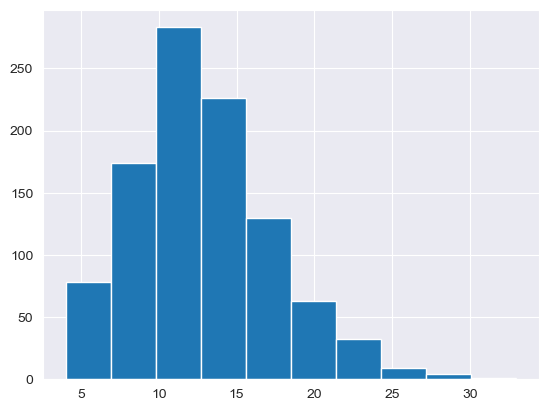

In [23]:
df.vec.apply(len).hist()

In [4]:
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# Dataset definition remains the same
class SequenceDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = [torch.tensor(seq, dtype=torch.float32) for seq in sequences]
        self.targets = torch.tensor(targets, dtype=torch.float32).view(-1, 1)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, index):
        sequence = self.sequences[index]
        target = self.targets[index]
        return sequence, target

In [5]:
import torch
from torch.utils.data import random_split
RANDOM_SEED = 42

torch.manual_seed(RANDOM_SEED)

dataset = SequenceDataset(df.vec.tolist(), df.val_acc)
train, val = random_split(dataset, [0.8, 0.2], generator=torch.Generator().manual_seed(RANDOM_SEED))

In [40]:
class LSTMRegressor(pl.LightningModule):
    def __init__(self, 
                 input_dim=32,                 
                 hidden_dim=128, 
                 num_layers=1, 
                 dropout=0.0, 
                 lr=1e-3,
                 gamma=0.9,
                 num_epochs=None,
                 **_):
        super().__init__()
        self.save_hyperparameters()  # Save hyperparameters
        self.lstm = torch.nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers=num_layers,
            dropout=dropout, 
            batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, 1)
        self.lr = lr
        self.gamma = gamma
        self.val_loss = None

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)       
        return self.fc(hidden[-1])

    def training_step(self, batch, batch_idx):
        sequences, targets = batch
        outputs = self(sequences)
        targets = targets.view(-1, 1)
        loss = F.mse_loss(outputs, targets)
        # self.log('train_loss', loss, on_step=True, on_epoch=False, prog_bar=False)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss
    
    # def validation_step(self, batch, batch_idx):
    #     sequences, targets = batch
    #     outputs = self(sequences)
    #     targets = targets.view(-1, 1)
    #     loss = F.mse_loss(outputs, targets)
    #     # self.log('val_loss', loss, on_step=True, on_epoch=False, prog_bar=False)
    #     self.val_loss = loss
    #     return loss    

    def on_train_end(self):
        # Log the hyperparameter metric directly here
        trainer = self.trainer
        if trainer.logger:
            trainer.logger.log_hyperparams({"hp_metric": self.val_loss})
    
    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(), lr=self.lr)
        return {
            'optimizer': opt,
            'lr_scheduler': torch.optim.lr_scheduler.ExponentialLR(opt, gamma=self.gamma)
        }

In [55]:
import warnings

warnings.filterwarnings("ignore", ".*Consider increasing the value of the `num_workers` argument*")

train_loader = DataLoader(train, batch_size=1, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val, batch_size=1, shuffle=False, num_workers=0, pin_memory=True)

hparams = {
    'lr': 1e-3,
    'gamma': 1,
    'hidden_dim': 32,
    'num_layers': 4,
    'dropout': 0.5,
    'input_dim': 32,
    'num_epochs': 20,
}

# Initialize model
model = LSTMRegressor(**hparams)

from tqdm import tqdm

# disable validation progress bar
from pytorch_lightning.callbacks import TQDMProgressBar
class CustomProgressBar(TQDMProgressBar):
    def init_validation_tqdm(self):
        return tqdm(disable=True)


# Create PyTorch Lightning trainer
trainer = pl.Trainer(max_epochs=hparams['num_epochs'], 
                     accelerator='gpu', 
                     log_every_n_steps=100,
                     callbacks=[CustomProgressBar()],
                     )

# Train the model
model.train()
trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\korol\miniforge3\envs\sophius\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:106: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params
--------------------------------
0 | lstm | LSTM   | 33.8 K
1 | fc   | Linear | 33    
--------------------------------
33.8 K    Trainable params
0         Non-trainable params
33.8 K    Total params
0.135     Total estimated model params size (MB)


Epoch 19: 100%|██████████| 800/800 [00:07<00:00, 107.28it/s, loss=0.00676, v_num=20, train_loss=0.00447]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 800/800 [00:07<00:00, 107.15it/s, loss=0.00676, v_num=20, train_loss=0.00447]


mse: 0.0037
r2: 0.6712


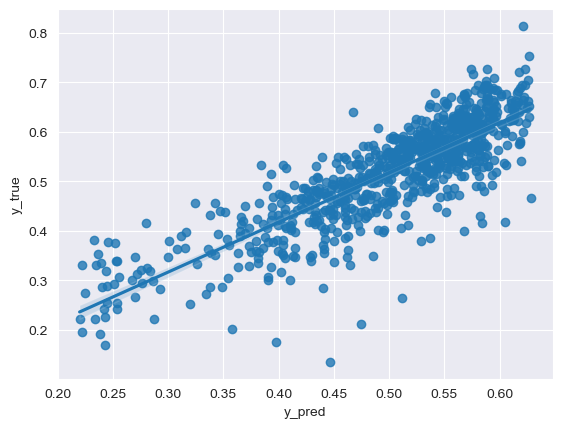

In [56]:
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score

def _predict(model, v: torch.Tensor):
    model.eval()
    with torch.no_grad():
        y_pred = model(v.unsqueeze(0))
    return y_pred


def plot_results(model, dataset):
    res = pd.DataFrame(columns=['y_pred', 'y_true'])

    for seq, y_true in dataset:    
        y_pred = _predict(model, seq).item()
        y_true = y_true.item()
        res.loc[len(res)] = [y_pred, y_true]
    
    print(f'mse: {mean_squared_error(res.y_true, res.y_pred):.4f}')
    print(f'r2: {r2_score(res.y_true, res.y_pred):.4f}')
    sns.regplot(res, x='y_pred', y='y_true');

plot_results(model, train)

mse: 0.0075
r2: 0.2791


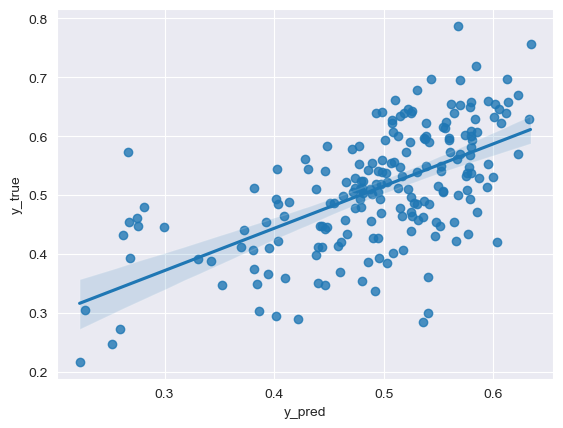

In [57]:
plot_results(model, val)